In [204]:
import sys, os, re
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy.stats import binned_statistic
import pickle
import pandas as pd
import yaml
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

sys.path.append('barcode')
import barcode
# importlib.reload(barcode.barcode_util)
# importlib.reload(barcode.extract_barcodes)
# importlib.reload(barcode.align_barcodes)

from barcode.extract_barcodes import extract_barcode
from barcode.align_barcodes import align_barcode
from barcode.barcode_util import read_h5, read_h5_with_key

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)
from neural_analysis_helpers import get_rewards, get_rewarded_landmarks, get_landmark_category_entries, get_landmark_category_rew_idx, \
    get_landmark_categories, load_vr_behaviour_data, load_nidaq_behaviour_data, get_lm_entry_exit, load_vr_session_info, get_position_info, \
    get_VR_rewards

import parse_session_functions
importlib.reload(parse_session_functions)

from parse_session_functions import load_session, load_config, create_session_struct, get_lap_idx, get_lm_idx, calc_laps_needed, get_active_goal, get_rewarded_lms, get_lms_visited



In [2]:
# Define relevant directories and session specific info
basepath = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')

# session = 'TAA0000066/ses-011_date-20250315_protocol-t5'
# session = 'TAA0000066/ses-012_date-20250318_protocol-t6'
# session = 'TAA0000066/ses-018_date-20250403_protocol-t12'
session = 'TAA0000066/ses-008_date-20250306_protocol-t3'
sess_data_path = basepath / session
func_img_path = 'funcimg/Session'
behav_dir = sess_data_path / 'behav'

# Extract protocol number
match = re.search(r'protocol-t(\d+)', session)
if match:
    protocol_number = int(match.group(1))
else:
    raise ValueError("Protocol number not found in session string")

# Define data files
func_img_header_fname = list((sess_data_path / func_img_path).glob("*.h5"))
if len(func_img_header_fname) > 1:
    raise ValueError('More than one .h5 files were found. Please correct...')
else: 
    func_img_header_fname = os.path.split(func_img_header_fname[0])[1]
vdaq_signals_file = sess_data_path / func_img_path / func_img_header_fname

behav_data_header_fname = os.path.split(list(behav_dir.glob("*ai.bin"))[0])[1]
behav_signals_file = behav_dir / behav_data_header_fname

rotary_data_header_fname = os.path.split(list(behav_dir.glob("*ci.bin"))[0])[1]

position_data_dir = [d for d in os.listdir(behav_dir) if d.isdigit() and len(d) == 6][0]

if 't0' not in session: 
    n_channels = 6    # TODO: automate the detection of AI channels
else:
    n_channels = 4

# Read training stage
config_file = os.path.join(sess_data_path, 'behav', position_data_dir, 'config.yaml')
with open(config_file, 'r') as fd:
    options = yaml.load(fd, Loader=yaml.SafeLoader)  

rulename = options['sequence_task']['rulename']
if rulename == 'run-auto' or rulename == 'run-lick':  # stages 1-2
    start_odour = False  # VR started with reward delivery
# elif rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
else:
    start_odour = True  # first VR event was the odour delivery prep

# Recording params
nidaq_sampling_rate = 9000
vdaq_sampling_rate = 5000
funcimg_frame_rate = 45  # frames/s
if protocol_number <= 5:
    funcimg_recording_duration = 30 # min 
else: 
    funcimg_recording_duration = 45
    
save_npz = True
save_csv = True

In [3]:
# Load NIDAQ behaviour data 
ai_data_lin = np.fromfile(behav_signals_file, dtype=np.float64)
reclen = int(int(ai_data_lin.shape[0])/n_channels)
ai_data = np.reshape(ai_data_lin,[reclen,n_channels])

rotary_signals_file = behav_dir / rotary_data_header_fname
ci_data = np.fromfile(rotary_signals_file, dtype=np.float64)

In [9]:
# Load VR data 
VR_data, options = load_vr_behaviour_data(sess_data_path)
session = create_session_struct(VR_data, options)
session = get_lap_idx(session)
session = get_lm_idx(session)
session = get_rewarded_lms(session)
session = get_active_goal(session)
session = calc_laps_needed(session)
session = get_lms_visited(options, session)

print('Number of laps:', session['num_laps'])
num_lms = len(session['all_landmarks'])
print('Number of landmarks visited:', num_lms)

# rewards_VR, assistant_reward_idx, manual_reward_idx = get_VR_rewards(VR_data)
all_rewards_VR = np.sort(np.concatenate([session['rewards'], session['assist_rewards'], session['manual_rewards']]))
first_reward = np.min(all_rewards_VR)
print('First reward was delivered', np.round(session['time'][first_reward] - session['time'][0], 2), 's after VR start.')

rulename = options['sequence_task']['rulename']
if rulename == 'run-auto' or rulename == 'run-lick':  # stages 1-2
    start_odour = False  # VR started with reward delivery
elif rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
    start_odour = True  # first VR event was the odour delivery prep

    if rulename == 'olfactory_test':
        num_landmarks = 10
    else:
        num_landmarks = 2
        # print('Please specify the number of landmarks in the corridor!')  # TODO: read this from config file


Speed threshold: 5
Number of laps: 5
Number of landmarks visited: 822
First reward was delivered 1.99 s after VR start.


## Extract barcodes
**TODO**: Some barcodes are wrong. The alignment still works, but need to look into that!

In [16]:
# Extract barcodes for imaging
force_reload = 0
vdaq_barcode_file = sess_data_path / func_img_path / (func_img_header_fname.split('.')[0] + '_barcode.npy')

if os.path.exists(vdaq_barcode_file) and not force_reload:
    print('VDAQ barcodes detected. Loading...')
    vdaq_SyncTTL_ts = np.load(vdaq_barcode_file)
else:
    extract_barcode(sess_data_path = sess_data_path, 
                    func_img_path = func_img_path,
                    func_img_header_fname = func_img_header_fname, 
                    expected_sample_rate = 5000) 
    vdaq_SyncTTL_ts = np.load(vdaq_barcode_file)

VDAQ barcodes detected. Loading...


In [17]:
# Extract barcodes for behaviour
force_reload = 0
behav_barcode_file = behav_dir / (behav_data_header_fname.split('.')[0] + '_barcode.npy')

if os.path.exists(behav_barcode_file) and not force_reload:
    print('Behav barcodes detected. Loading...')
    behav_SyncTTL_ts = np.load(behav_barcode_file)
else:
    extract_barcode(sess_data_path = sess_data_path,
                    behav_data_header_fname = behav_data_header_fname,
                    expected_sample_rate = 9000, n_channels=n_channels)
    behav_SyncTTL_ts = np.load(behav_barcode_file)

Behav barcodes detected. Loading...


In [18]:
# Load funcimg data
vdaq_BehavDaqSyncTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='TriggerFromBehavDAQ'))
vdaq_FrameTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='FrameTTL'))
vdaq_SyncTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='SyncTTL')) # USE THIS

In [19]:
# Extraction safety checks
plot_barcodes = False 

## (1) SAFETY CHECK - barcodes should be in increasing order 
barcode_timestamps_row = 0 # Same for both main and secondary, because we used our own code
barcodes_row = 1 # Same for both main and secondary

secondary_numpy_barcode = vdaq_SyncTTL_ts[barcodes_row, :]
secondary_numpy_timestamp = vdaq_SyncTTL_ts[barcode_timestamps_row, :]

main_numpy_barcode = behav_SyncTTL_ts[barcodes_row, :]
main_numpy_timestamp = behav_SyncTTL_ts[barcode_timestamps_row, :]

if len(np.where(np.diff(main_numpy_barcode) != 1)[0]) != 0:
    print('Look into the barcode extraction code from the NIDAQ. Something is wrong...') 

if len(np.where(np.diff(secondary_numpy_barcode) != 1)[0]) != 0:
    # Exclude last barcode, it might be off for other reasons. 
    print('Look into the barcode extraction code from the vDAQ. Something is wrong...') 


## (2) SAFETY CHECK - vdaq timestamps saved should align with TTL up
if plot_barcodes: 
    ttl_start = secondary_numpy_timestamp 
    display_range = 100000

    fig, ax = plt.subplots(2, 1)
    ax.ravel
    ax[0].plot(vdaq_SyncTTL[0:display_range])
    ax[0].scatter(ttl_start[np.where(ttl_start<=display_range)[0]], np.zeros((len(ttl_start[np.where(ttl_start<=display_range)[0]]), 1)), 10, 'r')

    ax[1].plot(np.arange(len(vdaq_SyncTTL)-display_range, len(vdaq_SyncTTL)), vdaq_SyncTTL[-display_range:])
    samples_to_plot = ttl_start[np.where(ttl_start>=len(vdaq_SyncTTL)-display_range)[0]]
    ax[1].scatter(samples_to_plot, np.zeros((len(samples_to_plot), 1)), 10, 'r')


## (3) SAFETY CHECK - behavior timestamps saved should align with TTL up
if plot_barcodes: 
    ttl_start = main_numpy_timestamp 
    plot_data = ai_data[:,0]
    display_range = 100000

    fig, ax = plt.subplots(2, 1)
    ax.ravel
    ax[0].plot(plot_data[0:display_range])
    ax[0].scatter(ttl_start[np.where(ttl_start<=display_range)[0]], np.zeros((len(ttl_start[np.where(ttl_start<=display_range)[0]]), 1)), 10, 'r')

    ax[1].plot(np.arange(len(plot_data)-display_range, len(plot_data)), plot_data[-display_range:])
    samples_to_plot = ttl_start[np.where(ttl_start>=len(plot_data)-display_range)[0]]
    ax[1].scatter(samples_to_plot, np.zeros((len(samples_to_plot), 1)), 10, 'r')

Look into the barcode extraction code from the NIDAQ. Something is wrong...
Look into the barcode extraction code from the vDAQ. Something is wrong...


## Align behaviour and funcimg barcodes and frames

In [20]:
# Align funcimg/frames and behav timestamps 
# Note that the indices of the frames are loaded here (not the timestamps)
force_reload = 0

aligned_barcode_file = sess_data_path / func_img_path / 'nidaq_aligned_ts.npy'
aligned_frame_file = sess_data_path / func_img_path / 'nidaq_aligned_frames.npy'
trans_vars_file = sess_data_path / func_img_path / 'nidaq_alignment_trans_vars.pkl'

if os.path.exists(aligned_barcode_file) and not force_reload:
    print('Aligned barcodes found. Loading...')
    aligned_SyncTTL_ts = np.load(aligned_barcode_file)
    
else:
    slope, offset = align_barcode(sess_data_path = sess_data_path, 
                            func_img_path = func_img_path, 
                            func_img_header_fname = func_img_header_fname, 
                            behav_data_header_fname = behav_data_header_fname, 
                            n_channels=n_channels, 
                            convert_frames=True, 
                            save_trans=True)
    aligned_SyncTTL_ts = np.load(aligned_barcode_file)

if os.path.exists(aligned_frame_file):
    print('Aligned imaging frames found. Loading...')
    aligned_FrameTTL = np.load(aligned_frame_file)

else:
    slope, offset = align_barcode(sess_data_path = sess_data_path, 
                            func_img_path = func_img_path,
                            func_img_header_fname = func_img_header_fname, 
                            behav_data_header_fname = behav_data_header_fname, 
                            n_channels=n_channels, 
                            convert_frames=True, 
                            save_trans=True)
    aligned_FrameTTL = np.load(aligned_frame_file)
    
# Load transformation variables (slope & offset)
if os.path.exists(trans_vars_file):
    print('Loading slope and offset...')
    with open(trans_vars_file, "rb") as f:
        trans = pickle.load(f)

    slope = trans["slope"]
    offset = trans["offset"]

Aligned barcodes found. Loading...
Aligned imaging frames found. Loading...
Loading slope and offset...


In [21]:
# Confirm transformation makes sense (TODO: maybe redundant?)
# Before alignment
shared_ts, behav_idx, vdaq_idx = np.intersect1d(behav_SyncTTL_ts[barcodes_row, :], vdaq_SyncTTL_ts[barcodes_row,:], return_indices=True) 
print(f"Before alignment:\n 1st behav ts from common barcodes: {behav_SyncTTL_ts[barcode_timestamps_row, behav_idx[0]]} \n 1st vdaq ts from common barcodes: {vdaq_SyncTTL_ts[barcode_timestamps_row, vdaq_idx[0]]}")

# After alignment 
aligned_shared_ts, aligned_behav_idx, aligned_vdaq_idx = np.intersect1d(behav_SyncTTL_ts[barcodes_row, :], aligned_SyncTTL_ts[barcodes_row, :], return_indices=True)
print(f"After alignment:\n 1st behav ts from common barcodes: {behav_SyncTTL_ts[barcode_timestamps_row, aligned_behav_idx[0]]} \n 1st vdaq ts from common barcodes: {aligned_SyncTTL_ts[barcode_timestamps_row, aligned_vdaq_idx[0]]}")

if int(vdaq_SyncTTL_ts[barcode_timestamps_row, vdaq_idx[0]] * slope + offset) == aligned_SyncTTL_ts[barcode_timestamps_row, aligned_vdaq_idx[0]]:
    print("Transformation makes sense!")

Before alignment:
 1st behav ts from common barcodes: 67038 
 1st vdaq ts from common barcodes: 3681
After alignment:
 1st behav ts from common barcodes: 67038 
 1st vdaq ts from common barcodes: 67038
Transformation makes sense!


## Extract behaviour-relevant imaging frames

In [26]:
# Confirm the correct number of frames has been detected
plot_frames = False

print("Number of frames expected: ", funcimg_frame_rate * funcimg_recording_duration * 60)

# FrameTTL_index, _ = find_peaks(np.diff(vdaq_FrameTTL), height=2)
binary_ttl = vdaq_FrameTTL > 4.5  # Convert to binary: 0 (low) / 1 (high)
FrameTTL_index = np.where(np.diff(binary_ttl.astype(int)) == 1)[0] -1
print("Number of frames detected: ", len(FrameTTL_index))

if plot_frames:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=vdaq_FrameTTL, mode='lines'))
    fig.add_trace(go.Scatter(x=FrameTTL_index, y=[vdaq_FrameTTL[i] for i in FrameTTL_index], mode='markers', marker=dict(size=4, color='red')))
    fig.write_html('FrameTTL_test.html')
    fig.show()

Number of frames expected:  81000
Number of frames detected:  81000


In [27]:
# Confirm time offsets make sense
modd1_start = np.where(np.abs(np.diff(ai_data[:,4])) >= 1)[0][0] 
modd2_start = np.where(np.abs(np.diff(ai_data[:,5])) >= 1)[0][0] 
modd_start_idx = np.min((modd1_start, modd2_start))  
print('First MODD after logging start:', modd_start_idx / nidaq_sampling_rate)

first_rew_idx = np.where(np.abs(np.diff(ai_data[modd_start_idx::,2])) >= 1)[0][0]
print('First reward after first MODD:', first_rew_idx / nidaq_sampling_rate)

print('First reward after logging start:', np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0] / nidaq_sampling_rate)

First MODD after logging start: 18.787333333333333
First reward after first MODD: 0.48333333333333334
First reward after logging start: 19.270666666666667


In [28]:
##### Find frames within NIDAQ logging #####
plot_timestamps = False

# valid_barcode_ts = aligned_SyncTTL_ts[0, (aligned_SyncTTL_ts[0, :] >= behav_SyncTTL_ts[0, 0]) & 
#                                          (aligned_SyncTTL_ts[0, :] <= behav_SyncTTL_ts[0, -1])]

# valid_frames_nidaq = aligned_FrameTTL[(aligned_FrameTTL >= valid_barcode_ts[0]) & 
#                                       (aligned_FrameTTL <= valid_barcode_ts[-1])]
valid_frames_nidaq = aligned_FrameTTL[(aligned_FrameTTL >= behav_SyncTTL_ts[0,0]) & 
                                      (aligned_FrameTTL <= behav_SyncTTL_ts[0,-1])]

valid_frames_ts_nidaq = valid_frames_nidaq / nidaq_sampling_rate   # convert frame samples to timestamps according to main sampling rate

# Find nidaq start and end timestamps
nidaq_times_start = behav_SyncTTL_ts[0,0] / nidaq_sampling_rate 
nidaq_times_end = behav_SyncTTL_ts[0,-1] / nidaq_sampling_rate 

print('Number of frames within NIDAQ logging: ', len(valid_frames_ts_nidaq))

##### Find frames within VR behaviour #####
if start_odour:
    # The time offset in the reward shows how far into the nidaq logging the VR started.
    first_rew_idx = np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0]
    time_offset = session['time'][first_reward] - first_rew_idx / nidaq_sampling_rate
    print('Time offset:', time_offset)

    # behav_start_ts = np.abs(first_rew_idx / nidaq_sampling_rate - session['time'][first_reward]) 
    behav_start_ts = np.abs(time_offset) #- session['time'][0]
    behav_start_idx = int(np.round(behav_start_ts * nidaq_sampling_rate))
else:
    first_rew_idx = np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0]  
    behav_start_idx = first_rew_idx  # behaviour started when first reward was delivered
    behav_start_ts = behav_start_idx / nidaq_sampling_rate

# behav_start_ts = times[0] + behav_start_idx / nidaq_sampling_rate

# behav_end_ts = times[-1] + times[0] + behav_start_ts  # VR is using its own clock, but there is an offset at the start 
behav_end_ts = session['time'][-1] + behav_start_ts    # VR start is ~0 (small offset), but NIDAQ first reward is at behav_start_ts
behav_end_idx = int(behav_end_ts * nidaq_sampling_rate)

if behav_end_ts > valid_frames_ts_nidaq[-1]:
    print('Warning! Funcimg stopped before the VR.')
    
valid_frames_behav_idx = np.where((valid_frames_ts_nidaq >= behav_start_ts) & (valid_frames_ts_nidaq <= behav_end_ts))[0]
valid_frames_behav = valid_frames_ts_nidaq[valid_frames_behav_idx]
# first_valid_frame = valid_frames_ts_nidaq[np.where(valid_frames_ts_nidaq < behav_start_ts)[0][-1]]
# last_valid_frame = valid_frames_ts_nidaq[np.where(valid_frames_ts_nidaq > behav_end_ts)[0][0]]  # TODO: will be relevant when funcimg stops after behav
# valid_frames_behav = np.insert(valid_frames_behav, 0, first_valid_frame) 
# valid_frames_behav = np.insert(valid_frames_behav, -1, last_valid_frame)

behav_idx = np.arange(behav_start_idx, behav_end_idx, 1)
behav_times = behav_idx / nidaq_sampling_rate 

#### Display timestamps ####
print('\nNIDAQ logging started at: ', 0, ', but first barcode TTL was at: ', nidaq_times_start)   
print('vDAQ/funcimg started at: ', aligned_FrameTTL[0] / nidaq_sampling_rate)
print('VR started at: ', behav_start_ts)
print('VR stopped at: ', behav_end_ts)
print('vDAQ/funcimg stopped at: ', aligned_FrameTTL[-1] / nidaq_sampling_rate)
print('NIDAQ logging stopped at: ', len(ai_data[:,0]) / nidaq_sampling_rate, ', but last barcode TTL was at: ', nidaq_times_end)

print('\nNumber of frames within VR behaviour: ', len(valid_frames_behav))

print('Total imaging time with behaviour: ', len(valid_frames_behav) / funcimg_frame_rate) 
print('Total imaging time should be: ', len(FrameTTL_index) / funcimg_frame_rate, ', but it is: ', (aligned_FrameTTL[-1] / nidaq_sampling_rate) - (aligned_FrameTTL[-0] / nidaq_sampling_rate))
print('\nImaging duration according to VR = ', session['time'][-1], 'and according to NIDAQ timestamps = ', behav_end_ts - behav_start_ts)


if plot_timestamps: 
    # Plot frame TTL and find where NIDAQ and VR start (in indices)
    fig, ax = plt.subplots(3, 1)
    ax = ax.ravel()

    ax[0].plot(ai_data[:,2])
    ax[0].plot(behav_start_idx, 0, 'go', label='VR start')
    ax[0].plot(behav_end_idx, 0, 'co', label='VR end')
    ax[0].legend(loc='upper right')

    ax[1].scatter(valid_frames_behav[:100], np.ones(len(valid_frames_behav[:100])), 5, label='First few funcimg frames')
    ax[1].vlines(x=nidaq_times_start, ymin=0, ymax=5, colors='r', label='NIDAQ logging start')
    ax[1].vlines(x=behav_start_ts, ymin=0, ymax=5, colors='g', label='VR start')
    ax[1].legend(loc='upper right')

    ax[2].scatter(valid_frames_behav[-100:], np.ones(len(valid_frames_behav[-100:])), 5, label='Last few funcimg frames')
    ax[2].vlines(x=nidaq_times_end, ymin=0, ymax=5, colors='r', label='NIDAQ logging end')
    ax[2].vlines(x=behav_end_ts, ymin=0, ymax=5, colors='g', label='VR end')
    ax[2].legend(loc='upper right')


Number of frames within NIDAQ logging:  81000
Time offset: -16.199138766666668

NIDAQ logging started at:  0 , but first barcode TTL was at:  0.43122222222222223
vDAQ/funcimg started at:  9.758222222222223
VR started at:  16.199138766666668
VR stopped at:  1774.8201288666667
vDAQ/funcimg stopped at:  1821.411111111111
NIDAQ logging stopped at:  1827.3333333333333 , but last barcode TTL was at:  1826.9706666666666

Number of frames within VR behaviour:  78628
Total imaging time with behaviour:  1747.2888888888888
Total imaging time should be:  1800.0 , but it is:  1811.6528888888888

Imaging duration according to VR =  1758.6209901 and according to NIDAQ timestamps =  1758.6209901


In [29]:
# What is going on with imaging time? 
print('AFTER ALIGNMENT')
print('Funcimg duration is: ', aligned_FrameTTL[-1] / nidaq_sampling_rate - aligned_FrameTTL[0] / nidaq_sampling_rate)
print('The number of frames is: ', len(aligned_FrameTTL))
print('The frame rate has also been rescaled so that this should be ~ 1: ', \
      np.mean(np.diff(aligned_FrameTTL) / (nidaq_sampling_rate / funcimg_frame_rate)))

print('\nBEFORE ALIGNMENT')
print('Funcimg duration is: ', (FrameTTL_index[-1] - FrameTTL_index[0]) / vdaq_sampling_rate)
print('That means that the actual frame rate is: ', 1 / np.mean(np.diff(FrameTTL_index / vdaq_sampling_rate)))

AFTER ALIGNMENT
Funcimg duration is:  1811.6528888888888
The number of frames is:  81000
The frame rate has also been rescaled so that this should be ~ 1:  1.0064862529167025

BEFORE ALIGNMENT
Funcimg duration is:  1811.6498
That means that the actual frame rate is:  44.71007586565571


## Deal with position data (distance, position, speed)
**TODO**: Figure out where the distance offset comes from

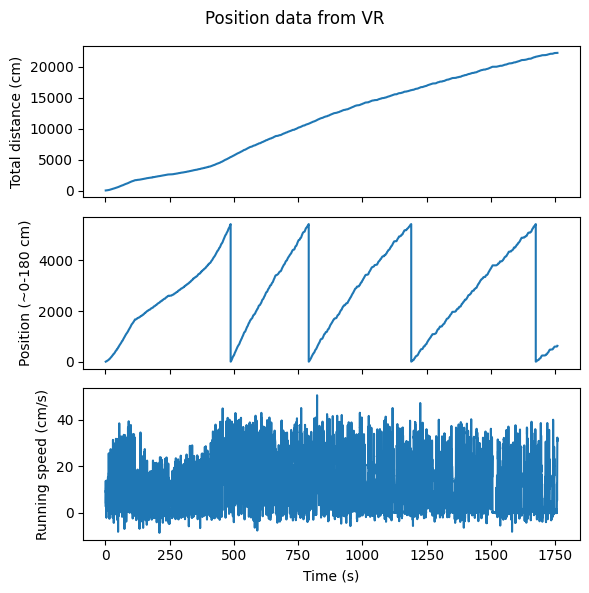

In [30]:
# VR position data
fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Position data from VR')

ax[0].plot(session['time'], session['total_dist'])
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(session['time'], session['position'])
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(session['time'], session['speed'])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')

plt.tight_layout()

In [31]:
#### Calculate speed based on rotary encoder NIDAQ output 

# # Convert angular rotary encoder output to linear position
# diameter = 19.7
# ppr = 1000
# effective_ppr = ppr #* 4  # Already adjusted for quadrature decoding 
# linear_position = ci_data[:] / effective_ppr * np.pi * diameter 

# nidaq_total_dist = linear_position[behav_idx] - linear_position[behav_start_idx]
# nidaq_total_dist = nidaq_total_dist * options['base_tunnel']['speed_gain']

# # To account for the quantization effect, a moving average is used for speed calculation
# nidaq_speed = np.diff(nidaq_total_dist) / np.diff(behav_times) 
# dt = 1 / nidaq_sampling_rate
# nidaq_speed = np.diff(nidaq_total_dist) / dt
# nidaq_speed = np.append(nidaq_speed, nidaq_speed[-1])

# window_size = int(nidaq_sampling_rate / 60) # Use VR sampling rate (approx)
# nidaq_speed = uniform_filter1d(nidaq_speed, size=window_size, mode='nearest')

# nidaq_position = nidaq_total_dist + np.array(options['flip_tunnel']['margin_start'])
# nidaq_position = np.zeros(len(nidaq_total_dist))
# nidaq_position[0] = total_dist[0]
# for i in range(1, len(nidaq_total_dist)):
#    nidaq_position[i] = nidaq_position[i-1] + nidaq_total_dist[i] - nidaq_total_dist[i-1]
#    if nidaq_position[i] > options['flip_tunnel']['length']:  # reset to beginning of track
#         nidaq_position[i] -= options['flip_tunnel']['length']

# # NIDAQ position data 
# fig, ax2 = plt.subplots(3, 1, figsize=(6,6), sharex=True)
# ax2 = ax2.ravel()
# fig.suptitle('Position data from NIDAQ CI')

# shifted_behav_times = behav_times - behav_times[0]
# idx_plot = behav_idx - behav_idx[0]

# ax2[0].plot(shifted_behav_times, nidaq_total_dist[idx_plot])
# ax2[0].set_ylabel('Total distance (cm)') 

# ax2[1].plot(shifted_behav_times, nidaq_position[idx_plot])
# ax2[1].set_ylabel('Position (~0-180 cm)')

# ax2[2].plot(shifted_behav_times, nidaq_speed[idx_plot])
# ax2[2].set_xlabel('Time (s)')
# ax2[2].set_ylabel('Running speed (cm/s)')

# # ax[0].set_ylim(ax2[0].get_ylim())  
# # ax[1].set_ylim(ax2[1].get_ylim())  
# # ax[2].set_ylim(ax2[2].get_ylim())  

# print('Difference in total distance (VR - DAQ ctr) = ', (total_dist[-1] - total_dist[0]) - (nidaq_total_dist[-1] - nidaq_total_dist[0]))    # TODO: why and in what units?

# Plot an overlap of position determined from VR vs NIDAQ 
# plt.figure()
# plt.plot(times, total_dist, 'b-', label='VR')
# plt.plot(shifted_behav_times, nidaq_total_dist[idx_plot], 'c-', label='NIDAQ')
# plt.legend(loc='upper left')

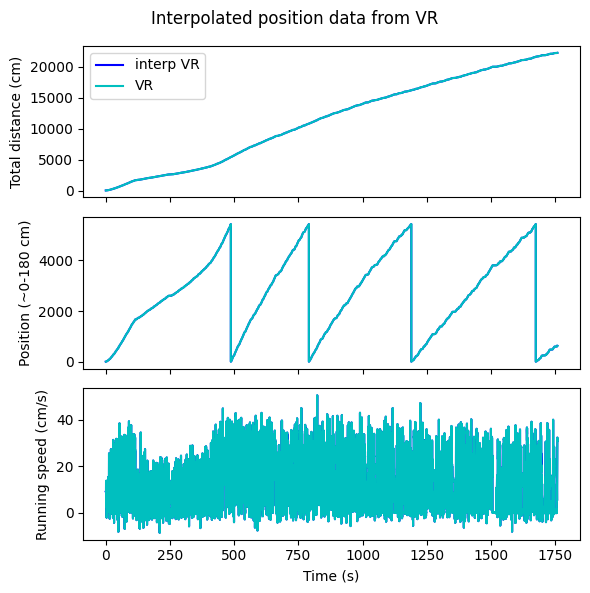

In [180]:
# Interpolate VR position, speed, total distance
shifted_behav_times = behav_times - behav_times[0]  # reset nidaq times to 0 to match VR

interp_total_dist = np.interp(shifted_behav_times, session['time'], session['total_dist'])
interp_speed = np.interp(shifted_behav_times, session['time'], session['speed'])

if session['num_laps'] == 1:
    interp_position = np.interp(shifted_behav_times, session['time'], session['position'])
else:
    period = int(np.round(session['position'].max() - session['position'].min()))  

    unwrapped_position = session['position'].copy()
    for i in range(1, len(session['position'])):
        diff = unwrapped_position[i] - unwrapped_position[i-1]
        if diff < -period / 2:
            unwrapped_position[i:] += period
        elif diff > period / 2:
            unwrapped_position[i:] -= period

    interp_unwrapped = np.interp(shifted_behav_times, session['time'], unwrapped_position)
    interp_position = (interp_unwrapped - np.min(session['position'])) % period + np.min(session['position'])

# Visually confirm interpolation makes sense
fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Interpolated position data from VR')

ax[0].plot(shifted_behav_times, interp_total_dist, 'b-', label='interp VR')
ax[0].plot(session['time'], session['total_dist'], 'c-', label='VR')
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(shifted_behav_times, interp_position, 'b-', label='interp VR')
ax[1].plot(session['time'], session['position'], 'c-', label='VR')
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(shifted_behav_times, interp_speed, 'b-', label='interp VR')
ax[2].plot(session['time'], session['speed'], 'c-', label='VR')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')

ax[0].legend(loc='upper left')
plt.tight_layout()

## Create output for further analysis

**TODO**: Add the behaviour videos

In [181]:
# Collect all data 
binary_rewards = ai_data[behav_idx,2] > 1
reward_idx = np.where(np.diff(binary_rewards.astype(int)) >= 1)[0] - 1
bin_reward = np.zeros_like(ai_data[behav_idx, 2])
bin_reward[reward_idx + 1] = 1  
reward_times = reward_idx / nidaq_sampling_rate 

binary_licks = ai_data[behav_idx,1] > 1  
lick_idx = np.where(np.diff(binary_licks.astype(int)) == 1)[0] - 1
bin_licks = np.zeros_like(ai_data[behav_idx,1])
bin_licks[lick_idx + 1] = 1
lick_times = lick_idx / nidaq_sampling_rate 

binary_modd1 = ai_data[behav_idx,4] > 1
modd1_idx = np.where(np.diff(binary_modd1.astype(int)) >= 1)[0] - 1
bin_modd1 = np.zeros_like(ai_data[behav_idx,4])
bin_modd1[modd1_idx + 1] = 1
modd1_times = modd1_idx / nidaq_sampling_rate

binary_modd2 = ai_data[behav_idx,5] > 1
modd2_idx = np.where(np.diff(binary_modd2.astype(int)) >= 1)[0] - 1
bin_modd2 = np.zeros_like(ai_data[behav_idx,5])
bin_modd2[modd2_idx + 1] = 1
modd2_times = modd2_idx / nidaq_sampling_rate

In [ ]:
# first_reward = np.min(all_rewards_VR)
# time_first_reward = session['time'][first_reward]

# first_rew_idx0 = np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0]
# binary_rewards = ai_data[behav_idx,2] > 1
# reward_idx = np.where(np.diff(binary_rewards.astype(int)) >= 1)[0] 
# bin_reward = np.zeros_like(ai_data[behav_idx, 2])
# bin_reward[reward_idx +1] = 1  
# reward_times = reward_idx / nidaq_sampling_rate 

# test = np.where(bin_reward == 1)[0]
# print(interp_position[test[0]])
# print(reward_times[6])

21.867978792210046
125.79033333333334


In [34]:
# Ensure data from NIDAQ and VR are consistent in length
# MODDs and landmarks visited 
print('Number of MODDs detected on NIDAQ: ', len(modd1_idx) + len(modd2_idx))
print('Number of landmarks visited: ', len(session['all_lms']))
if len(session['all_lms']) != len(modd1_idx) + len(modd2_idx):
    print('Something is wrong. Hopefully not too bad...')

# Licks
binary_licks = ai_data[:,1] > 1  # Convert to binary: 0 (low) / 1 (high)
lick_idx_test = np.where(np.diff(binary_licks.astype(int)) == 1)[0] 
print('Number of all licks on NIDAQ: ', len(np.where(np.diff(ai_data[:,1]) >= 1)[0]))
print('Number of licks detected on NIDAQ during VR: ', len(lick_idx))
print('Number of licks on VR: ', len(session['licks']))

# Rewards
print('Number of rewards detected on NIDAQ: ', len(reward_times))
print('Number of rewards on VR: ', len(all_rewards_VR))

Number of MODDs detected on NIDAQ:  709
Number of landmarks visited:  822
Something is wrong. Hopefully not too bad...
Number of all licks on NIDAQ:  1085
Number of licks detected on NIDAQ during VR:  1080
Number of licks on VR:  4663
Number of rewards detected on NIDAQ:  48
Number of rewards on VR:  48


In [182]:
# Create arrays of data binned by imaging frames 
reward_array, _, _ = binned_statistic(behav_times, bin_reward, statistic='sum', bins=valid_frames_behav)

lick_array, _, _ = binned_statistic(behav_times, bin_licks, statistic='sum', bins=valid_frames_behav)

modd1_array, _, _ = binned_statistic(behav_times, bin_modd1, statistic='sum', bins=valid_frames_behav)

modd2_array, _, _ = binned_statistic(behav_times, bin_modd2, statistic='sum', bins=valid_frames_behav)

assert len(reward_array) == len(valid_frames_behav) - 1, 'Something is wrong with the binning.'

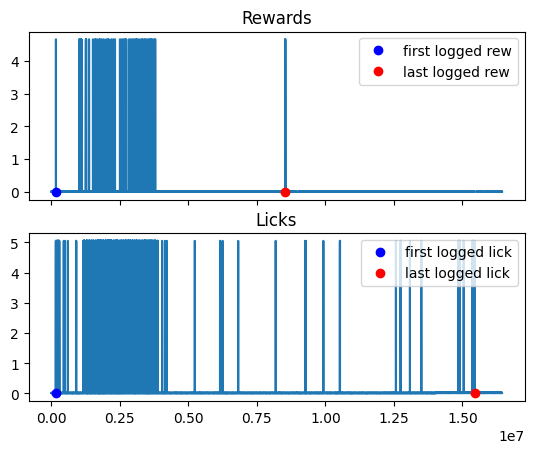

In [183]:
# Visually confirm the behaviour events during imaging

# REWARDS
first_idx_rew = np.where(np.array(reward_array) > 0)[0][0]
first_time_rew = valid_frames_behav[first_idx_rew]

last_idx_rew = np.where(np.array(reward_array) > 0)[0][-1]
last_time_rew = valid_frames_behav[last_idx_rew]

closest_time1_rew = behav_idx[np.argmin(np.abs(behav_times - first_time_rew))]
closest_time2_rew = behav_idx[np.argmin(np.abs(behav_times - last_time_rew))]

# LICKS
first_idx_licks = np.where(np.array(lick_array) > 0)[0][0]
first_time_licks = valid_frames_behav[first_idx_licks]

last_idx_licks = np.where(np.array(lick_array) > 0)[0][-1]
last_time_licks = valid_frames_behav[last_idx_licks]

closest_time1_licks = behav_idx[np.argmin(np.abs(behav_times - first_time_licks))]
closest_time2_licks = behav_idx[np.argmin(np.abs(behav_times - last_time_licks))]

# Plot
fig, ax = plt.subplots(2, 1, sharex=True)
ax = ax.ravel()

ax[0].plot(ai_data[:,2])
ax[0].plot(closest_time1_rew, 0, 'bo', label='first logged rew')
ax[0].plot(closest_time2_rew, 0, 'ro', label='last logged rew')
ax[0].legend(loc='upper right')
ax[0].title.set_text('Rewards')

ax[1].plot(ai_data[:,1])
ax[1].plot(closest_time1_licks, 0, 'bo', label='first logged lick')
ax[1].plot(closest_time2_licks, 0, 'ro', label='last logged lick')
ax[1].legend(loc='upper right')
ax[1].title.set_text('Licks')


Lap change
Lap change
Lap change
Lap change


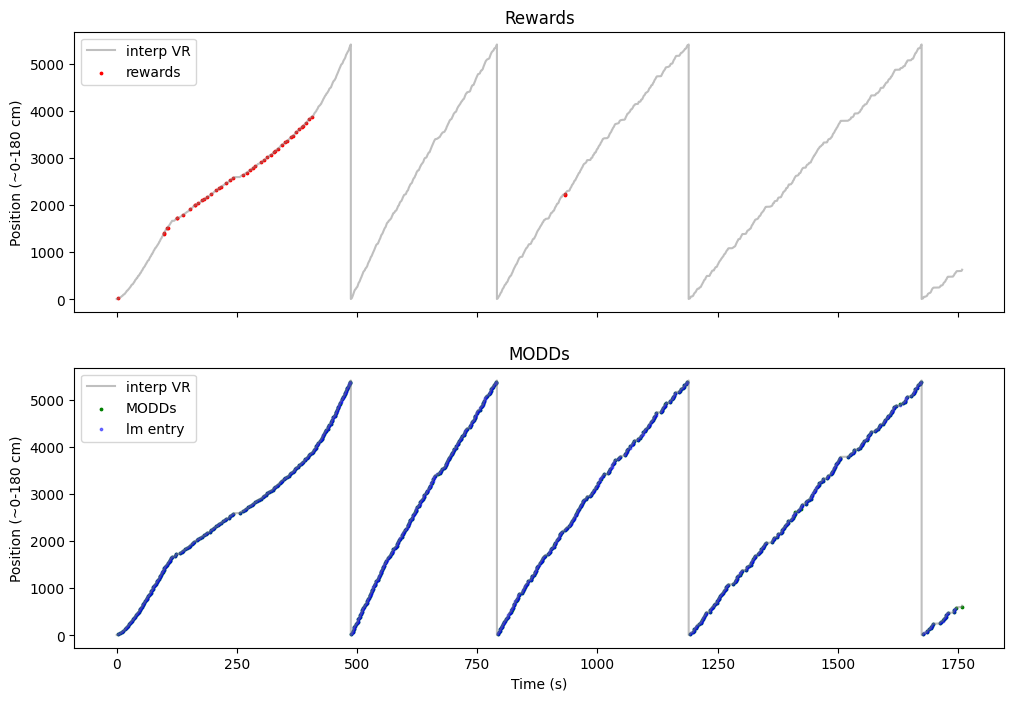

In [202]:
# Plot rewards, MODDs and landmark entries superimposed on position
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
ax = ax.ravel()

# Rewards
ax[0].plot(shifted_behav_times, interp_position, 'gray', label='interp VR', alpha=0.5)
ax[0].scatter(reward_times, interp_position[reward_idx], s=3, color='r', label='rewards')
ax[0].set_ylabel('Position (~0-180 cm)')
ax[0].set_title('Rewards')
ax[0].legend()

# MODDs and landmark entries
all_modd_times = np.sort(np.concatenate([modd1_times, modd2_times]))
all_modd_idx = np.sort(np.concatenate([modd1_idx, modd2_idx]))

lm_entry_idx, _ = get_lm_entry_exit(session, interp_position)  # TODO 

ax[1].plot(shifted_behav_times, interp_position, 'gray', label='interp VR', alpha=0.5)
ax[1].scatter(all_modd_times, interp_position[all_modd_idx], s=3, color='g', label='MODDs')
ax[1].scatter(shifted_behav_times[lm_entry_idx], interp_position[lm_entry_idx], s=3, color='b', alpha=0.5, label='lm entry')
ax[1].set_ylabel('Position (~0-180 cm)')
ax[1].set_title('MODDs')

ax[1].set_xlabel('Time (s)')
ax[1].legend()

In [185]:
# Create arrays of position-related data binned by imaging frames 
speed_array, _, _ = binned_statistic(behav_times, interp_speed, statistic='mean', bins=valid_frames_behav)

position_array, _, _ = binned_statistic(behav_times, interp_position, statistic='mean', bins=valid_frames_behav)

total_dist_array, _, _ = binned_statistic(behav_times, interp_total_dist, statistic='mean', bins=valid_frames_behav)

# assert len(speed_array) == len(valid_frames_behav) - 1, 'Something is wrong with the logged speed.'

In [ ]:
# TESTING 
lm_entry_idx, _ = get_lm_entry_exit(session, position_array) # TODO

fig, ax = plt.subplots(1, 1, figsize=(12,4), sharex=True, sharey=True)
# ax = ax.ravel()

modd_idx = (np.concatenate([np.where(modd1_array == 1)[0], np.where(modd2_array == 1)[0]]))
modd1_positions = position_array[np.where(modd1_array == 1)[0]]
modd2_positions = position_array[np.where(modd2_array == 1)[0]]
modd_positions = np.concatenate([modd1_positions, modd2_positions])

ax.plot(position_array, 'gray', label='interp VR', alpha=0.5)
ax.scatter(modd_idx, modd_positions, s=3, color='g', label='MODDs')
ax.scatter(np.array(lm_entry_idx), position_array[lm_entry_idx], s=3, color='b', alpha=0.5, label='lm entry')
ax.set_ylabel('Position (~0-180 cm)')
ax.set_title('MODDs')

Lap change


IndexError: index 0 is out of bounds for axis 0 with size 0

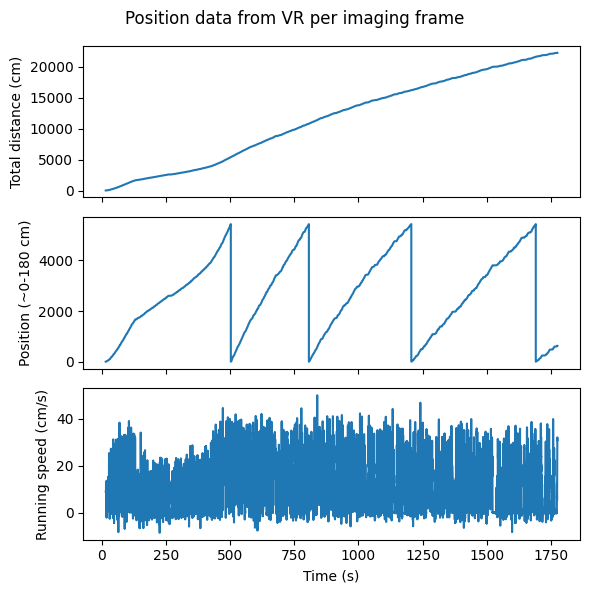

In [24]:
# Visually confirm the position data during imaging
window_size = 20    # arbitrary
# speed_array = uniform_filter1d(speed_array, size=window_size, mode='nearest')  # smoothing

fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Position data from VR per imaging frame')

ax[0].plot(valid_frames_behav[:-1], total_dist_array)
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(valid_frames_behav[:-1], position_array)
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(valid_frames_behav[:-1], speed_array)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')
plt.tight_layout()

[1.09040563e-02 4.80368902e-02 1.59298290e-02 8.33964945e-02
 2.69318866e+01 2.68751602e+01 1.01933813e-01 6.31566195e-03
 8.58094822e-03 1.30703279e-01 2.67780039e+01 1.04072198e-01
 1.40330604e-02 2.92662691e-01 2.18511137e-01 2.64109592e+01
 1.93463607e-01 2.54188397e-02 2.15954613e-01 3.92289941e-01
 2.62062077e+01 3.90189771e-02 2.74161917e-01 3.78354244e-02
 2.65468147e+01 9.99533825e-02 3.77682563e-01 2.55523093e-01
 2.62968319e+01 1.24667474e-02 5.06258882e-01 1.78742303e-02
 3.26863611e-01 2.61386143e+01 6.30834846e-02 1.93626362e-01
 1.05511480e-01 3.29555549e-01 2.62849109e+01 1.28889246e-01
 4.81203105e-02 5.78450652e-01 2.61386616e+01 3.61378240e-01
 8.64675912e-02 7.76150072e-02 4.18057925e-01 2.62010725e+01
 3.71781136e-02 3.55538454e-01 1.14652998e-01 2.64779437e+01
 1.05913654e-01 3.48632621e-01 4.09116189e-01 3.81568351e-02
 2.62399649e+01 1.13660642e-02 1.43422416e-01 2.27694141e-01
 2.63928288e+01 5.23281701e-01 1.29312049e-01 3.23224645e-02
 5.53075333e-02 2.646803

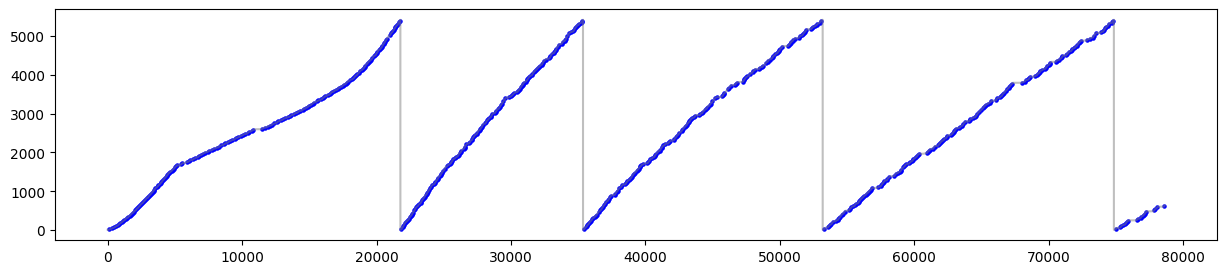

In [25]:
# Visually confirm consistent distance between MODDs
modd_idx = (np.concatenate([np.where(modd1_array == 1)[0], np.where(modd2_array == 1)[0]]))
modd1_positions = position_array[np.where(modd1_array == 1)[0]]
modd2_positions = position_array[np.where(modd2_array == 1)[0]]
modd_positions = np.concatenate([modd1_positions, modd2_positions])

np.set_printoptions(threshold=np.inf)
print(np.diff(np.sort(modd_positions)))

# Plot the binned MODDs superimposed on binned position
plt.figure(figsize=(15,3))
plt.plot(position_array, color='gray', alpha=0.5)

plt.scatter(modd_idx, modd_positions, s=5, c='b')

In [26]:
# Add calcium traces 
spikes = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p', 'plane0', 'spks.npy'))

# Keep spikes during behaviour 
behav_spikes = spikes[:, valid_frames_behav_idx]

In [27]:
# Save data
if save_npz: 
    np.savez_compressed(os.path.join(sess_data_path, 'behaviour_data.npz'), Ca_traces=behav_spikes, rewards=reward_array, licks=lick_array, \
             modd1=modd1_array, modd2=modd2_array, distance=total_dist_array, position=position_array, speed=speed_array)

if save_csv:  # Note spikes are not saved here - only behaviour
    df = pd.DataFrame({"Rewards": reward_array, "Licks": lick_array, "MODD1": modd1_array, "MODD2": modd2_array, \
                       "Distance": total_dist_array, "Position": position_array, "Speed": speed_array})
    df.to_csv(os.path.join(sess_data_path, 'behaviour_data.csv'), index=False)

np.savez_compressed(os.path.join(sess_data_path, 'valid_frames.npz'), valid_frames=valid_frames_behav_idx)